In [1]:
#!pip install shap

In [2]:
#pip install --upgrade pip


In [3]:
#!pip install toad

In [4]:
import toad

In [5]:
import pandas as pd
import numpy as np
import shap
#import shapely
from sklearn.model_selection import train_test_split

In [6]:
account = pd.read_csv("account.csv", sep = ';')
card = pd.read_csv("card.csv", sep = ';')
client = pd.read_csv("client.csv", sep = ';')
disp = pd.read_csv("disp.csv", sep = ';')
district = pd.read_csv("district.csv", sep = ';')
loan = pd.read_csv("loan.csv", sep = ';')
order = pd.read_csv("order.csv", sep = ';')
trans = pd.read_csv("trans.csv", sep = ';')

Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
account.rename(columns = {'date': 'account_date'}, inplace=True)
card.rename(columns = {'type': 'card_type'}, inplace=True)
card.rename(columns = {'issued': 'issued_date'}, inplace=True)
disp.rename(columns = {'type': 'disposition_type'}, inplace=True)
loan.rename(columns = {'date': 'loan_date'}, inplace=True)
loan.rename(columns = {'amount': 'loan_amount'}, inplace=True)
loan.rename(columns = {'duration': 'loan_duration'}, inplace=True)
trans.rename(columns = {'date': 'trans_date'}, inplace=True)
trans.rename(columns = {'amount': 'trans_amount'}, inplace=True)
trans.rename(columns = {'type': 'trans_type'}, inplace=True)

In [8]:
account.columns

Index(['account_id', 'district_id', 'frequency', 'account_date'], dtype='object')

In [9]:
card.columns

Index(['card_id', 'disp_id', 'card_type', 'issued_date'], dtype='object')

In [10]:
client.columns

Index(['client_id', 'birth_number', 'district_id'], dtype='object')

In [11]:
disp.columns

Index(['disp_id', 'client_id', 'account_id', 'disposition_type'], dtype='object')

In [12]:
loan.columns

Index(['loan_id', 'account_id', 'loan_date', 'loan_amount', 'loan_duration',
       'payments', 'status'],
      dtype='object')

In [13]:
trans.columns

Index(['trans_id', 'account_id', 'trans_date', 'trans_type', 'operation',
       'trans_amount', 'balance', 'k_symbol', 'bank', 'account'],
      dtype='object')

In [14]:
loan = pd.merge(loan , trans, how='left', left_on='account_id', right_on='account_id')
loan = pd.merge(loan, order ,how = 'left' ,left_on = 'account_id' , right_on ='account_id')
loan = pd.merge(loan , account, how='left', left_on='account_id', right_on='account_id')
#loan = pd.merge(loan, district ,how = 'left' ,left_on = 'district_id' , right_on ='district_id')
loan = pd.merge(loan , disp, how='left', left_on='account_id', right_on='account_id')
loan = pd.merge(loan, card ,how = 'left' ,left_on = 'disp_id' , right_on ='disp_id')

for col in loan:
    if col.endswith('_x'):
        loan.rename(columns = lambda col:col.rstrip('_x'),inplace=True)
    elif col.endswith('_y'):
        to_drop = [col for col in loan if col.endswith('_y')]
        loan.drop(to_drop,axis=1,inplace=True)
    else: 
        pass 

In [15]:
loan.head()

,loan_id,account_id,loan_date,loan_amount,loan_duration,payments,status,trans_id,trans_date,trans_type,...,amount,district_id,frequency,account_date,disp_id,client_id,disposition_type,card_id,card_type,issued_date
0,5314,1787,930705,96396,12,8033.0,B,523621,930322,PRIJEM,...,8033.2,30,POPLATEK TYDNE,930322,2166,2166,OWNER,NaN,NaN,NaN
1,5314,1787,930705,96396,12,8033.0,B,524054,930421,PRIJEM,...,8033.2,30,POPLATEK TYDNE,930322,2166,2166,OWNER,NaN,NaN,NaN
2,5314,1787,930705,96396,12,8033.0,B,524055,930521,PRIJEM,...,8033.2,30,POPLATEK TYDNE,930322,2166,2166,OWNER,NaN,NaN,NaN
3,5314,1787,930705,96396,12,8033.0,B,524056,930620,PRIJEM,...,8033.2,30,POPLATEK TYDNE,930322,2166,2166,OWNER,NaN,NaN,NaN
4,5314,1787,930705,96396,12,8033.0,B,523624,930708,PRIJEM,...,8033.2,30,POPLATEK TYDNE,930322,2166,2166,OWNER,NaN,NaN,NaN


In [16]:
loan = loan.drop(['loan_id','account_id','trans_id','order_id','client_id','card_id'],axis = 1)

In [89]:
loan[:1]

,loan_date,loan_amount,loan_duration,payments,status,trans_date,trans_type,operation,trans_amount,balance,...,bank_to,account_to,amount,district_id,frequency,account_date,disp_id,disposition_type,card_type,issued_date
0,930705,96396,12,8033.0,B,930322,PRIJEM,VKLAD,1100.0,1100.0,...,EF,8468449,8033.2,30,POPLATEK TYDNE,930322,2166,OWNER,NaN,NaN


In [17]:
loan.columns

Index(['loan_date', 'loan_amount', 'loan_duration', 'payments', 'status',
       'trans_date', 'trans_type', 'operation', 'trans_amount', 'balance',
       'k_symbol', 'bank', 'account', 'bank_to', 'account_to', 'amount',
       'district_id', 'frequency', 'account_date', 'disp_id',
       'disposition_type', 'card_type', 'issued_date'],
      dtype='object')

In [18]:
data = loan.copy()

In [19]:
#data = df['amount','status',]

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552017 entries, 0 to 552016
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   loan_date         552017 non-null  int64  
 1   loan_amount       552017 non-null  int64  
 2   loan_duration     552017 non-null  int64  
 3   payments          552017 non-null  float64
 4   status            552017 non-null  object 
 5   trans_date        552017 non-null  int64  
 6   trans_type        552017 non-null  object 
 7   operation         468062 non-null  object 
 8   trans_amount      552017 non-null  float64
 9   balance           552017 non-null  float64
 10  k_symbol          307269 non-null  object 
 11  bank              179512 non-null  object 
 12  account           211409 non-null  float64
 13  bank_to           552017 non-null  object 
 14  account_to        552017 non-null  int64  
 15  amount            552017 non-null  float64
 16  district_id       55

In [21]:
from sklearn.preprocessing import LabelEncoder
#data = data.apply(LabelEncoder().fit_transform)

In [22]:
data = data.sample(n=10000)
data.shape

(10000, 23)

In [23]:
data.columns

Index(['loan_date', 'loan_amount', 'loan_duration', 'payments', 'status',
       'trans_date', 'trans_type', 'operation', 'trans_amount', 'balance',
       'k_symbol', 'bank', 'account', 'bank_to', 'account_to', 'amount',
       'district_id', 'frequency', 'account_date', 'disp_id',
       'disposition_type', 'card_type', 'issued_date'],
      dtype='object')

In [24]:
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
data['status'] = labelencoder.fit_transform(data['status'])

In [25]:
data.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_date,trans_type,operation,trans_amount,balance,...,bank_to,account_to,amount,district_id,frequency,account_date,disp_id,disposition_type,card_type,issued_date
139023,941103,61056,48,1272.0,0,970331,PRIJEM,NaN,150.1,39642.0,...,UV,6799704,1978.0,1,POPLATEK MESICNE,931121,7241,OWNER,NaN,NaN
65954,940531,104808,12,8734.0,0,941209,PRIJEM,VKLAD,25970.0,51298.6,...,CD,85405385,735.0,66,POPLATEK MESICNE,931126,210,OWNER,NaN,NaN
470699,971208,30276,12,2523.0,0,961231,VYDAJ,VYBER,14.6,63153.5,...,YZ,1301700,2523.2,68,POPLATEK MESICNE,960728,31,OWNER,NaN,NaN
117808,940928,23052,12,1921.0,0,940124,VYDAJ,VYBER,4200.0,18331.8,...,WX,34075695,1921.0,54,POPLATEK MESICNE,930119,4621,DISPONENT,NaN,NaN
517338,980427,93888,36,2608.0,2,980106,PRIJEM,VKLAD,24155.0,53843.1,...,ST,27251911,2608.2,2,POPLATEK TYDNE,970616,3285,DISPONENT,NaN,NaN


In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [27]:
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33)
#X_train.shape , y_train.shape ,X_test.shape ,y_test.shape

In [28]:
#regression = LinearRegression()
#regression.fit(X_train,y_train)

In [29]:
#regressor  = RandomForestRegressor()
#regressor.fit(X_train,y_train)

In [30]:
#explainer = shap.TreeExplainer(regressor)
#shap_values = explainer.shap_values(X_train)

In [31]:
#shap.summary_plot(shap_values , X_train   , plot_type = "bar")

In [32]:
#shap.summary_plot(shap_values , X_train )

In [33]:
#shap.dependence_plot("total_acc",shap_values ,X_train )

In [34]:
#X_output = X_test.copy()
#X_output.loc[:,'predict'] = np.round(regressor.predict(X_output),2)

# Randomly pick some observations

#random_picks = np.arange(1,330,50) # Every 50 rows
#S = X_output.iloc[random_picks]
#S

In [35]:
#shap.initjs()

# Write in a function
#def shap_plot(j):
 #   explainerModel = shap.TreeExplainer(regressor)
  #  shap_values_Model = explainerModel.shap_values(S)
   # p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
   # return(p)


#shap_plot(0)

In [36]:
#X_train.mean()

In [37]:
data.shape

(10000, 23)

In [38]:
train = data.iloc[0:7000]
test = data.iloc[7000:10000]

In [39]:
test.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_date,trans_type,operation,trans_amount,balance,...,bank_to,account_to,amount,district_id,frequency,account_date,disp_id,disposition_type,card_type,issued_date
321838,960822,91152,24,3798.0,0,960509,VYDAJ,VYBER,8200.0,38830.5,...,EF,24082440,3798.2,32,POPLATEK MESICNE,950515,655,OWNER,classic,960808 00:00:00
330927,960926,96168,12,8014.0,0,961031,VYDAJ,VYBER,0.1,21800.7,...,QR,6911552,8013.7,64,POPLATEK TYDNE,950119,11771,OWNER,gold,981201 00:00:00
112380,940910,23628,12,1969.0,0,951126,VYDAJ,VYBER,52900.0,66284.6,...,EF,25279706,9503.0,38,POPLATEK MESICNE,930312,4428,OWNER,NaN,NaN
439901,970823,57120,48,1190.0,2,980415,VYDAJ,VYBER,1100.0,47527.0,...,EF,13832676,1682.0,32,POPLATEK MESICNE,961121,13097,OWNER,classic,980526 00:00:00
305085,960718,32640,48,680.0,2,960507,VYDAJ,PREVOD NA UCET,648.0,32794.2,...,QR,48447573,648.0,43,POPLATEK MESICNE,950324,6691,OWNER,NaN,NaN


In [40]:
train.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_date,trans_type,operation,trans_amount,balance,...,bank_to,account_to,amount,district_id,frequency,account_date,disp_id,disposition_type,card_type,issued_date
139023,941103,61056,48,1272.0,0,970331,PRIJEM,NaN,150.1,39642.0,...,UV,6799704,1978.0,1,POPLATEK MESICNE,931121,7241,OWNER,NaN,NaN
65954,940531,104808,12,8734.0,0,941209,PRIJEM,VKLAD,25970.0,51298.6,...,CD,85405385,735.0,66,POPLATEK MESICNE,931126,210,OWNER,NaN,NaN
470699,971208,30276,12,2523.0,0,961231,VYDAJ,VYBER,14.6,63153.5,...,YZ,1301700,2523.2,68,POPLATEK MESICNE,960728,31,OWNER,NaN,NaN
117808,940928,23052,12,1921.0,0,940124,VYDAJ,VYBER,4200.0,18331.8,...,WX,34075695,1921.0,54,POPLATEK MESICNE,930119,4621,DISPONENT,NaN,NaN
517338,980427,93888,36,2608.0,2,980106,PRIJEM,VKLAD,24155.0,53843.1,...,ST,27251911,2608.2,2,POPLATEK TYDNE,970616,3285,DISPONENT,NaN,NaN


In [41]:
print(train.shape ,test.shape)

(7000, 23) (3000, 23)


In [42]:
toad.detect(train)[:10]

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
loan_date,int64,7000,0.00%,540,957198.464,14784.756795,930705.0,930728.0,940406.9,960220.0,970610.75,980127.0,981029.0,981208.0
loan_amount,int64,7000,0.00%,623,140273.832,112736.541726,4980.0,8616.0,27456.0,99300.0,194160.0,309660.0,482940.0,590820.0
loan_duration,int64,7000,0.00%,5,34.961143,17.416629,12.0,12.0,12.0,36.0,48.0,60.0,60.0,60.0
payments,float64,7000,0.00%,561,4071.159714,2293.458844,304.0,359.0,1272.0,3698.0,5885.0,7279.0,9444.0,9910.0
status,int32,7000,0.00%,4,1.082,1.028591,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0
trans_date,int64,7000,0.00%,1492,966697.282429,13469.754622,930213.0,930915.97,950110.0,970528.0,980308.0,980831.0,981214.0,981231.0
trans_type,object,7000,0.00%,3,VYDAJ:64.31%,PRIJEM:33.20%,VYBER:2.49%,None,None,None,None,VYDAJ:64.31%,PRIJEM:33.20%,VYBER:2.49%
operation,object,7000,15.17%,5,VYBER:37.59%,PREVOD NA UCET:28.70%,VKLAD:14.09%,PREVOD Z UCTU:3.94%,VYBER KARTOU:0.51%,VYBER:37.59%,PREVOD NA UCET:28.70%,VKLAD:14.09%,PREVOD Z UCTU:3.94%,VYBER KARTOU:0.51%
trans_amount,float64,7000,0.00%,2954,7347.124471,11025.164019,0.1,14.6,15.0,3000.0,9000.0,22064.0,48752.64,74522.0
balance,float64,7000,0.00%,6825,43600.515871,23806.92187,-8470.4,3261.515,17866.23,38769.25,56330.3,77448.84,114711.83,160661.2


In [43]:
toad.quality(data,'status',iv_only=True)[:15]


,iv,gini,entropy,unique
loan_amount,1.895468,NaN,NaN,636.0
issued_date,1.357122,NaN,NaN,156.0
payments,1.356902,NaN,NaN,570.0
account_date,1.323987,NaN,NaN,550.0
district_id,1.026075,NaN,NaN,77.0
disposition_type,1.018254,NaN,NaN,2.0
disp_id,0.762044,NaN,NaN,815.0
loan_date,0.739834,NaN,NaN,553.0
balance,0.655271,NaN,NaN,9657.0
card_type,0.531536,NaN,NaN,4.0


In [44]:
train_selected, dropped = toad.selection.select(train ,target = 'status', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True)# exclude = ['issue_d','earliest_cr_line'])
print(dropped)
print(train_selected.shape)

{'empty': array(['bank', 'account', 'card_type', 'issued_date'], dtype='<U11'), 'iv': array(['trans_type', 'operation', 'k_symbol'], dtype=object), 'corr': array(['loan_date'], dtype=object)}
(7000, 15)


In [45]:
train_selected, dropped = toad.selection.select(train, target = 'status', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True )#  exclude = ['date'])
print(dropped)
print(train_selected.shape)


{'empty': array(['bank', 'account', 'card_type', 'issued_date'], dtype='<U11'), 'iv': array(['trans_type', 'operation', 'k_symbol'], dtype=object), 'corr': array(['loan_date'], dtype=object)}
(7000, 15)


In [46]:
train_selected.columns

Index(['loan_amount', 'loan_duration', 'payments', 'status', 'trans_date',
       'trans_amount', 'balance', 'bank_to', 'account_to', 'amount',
       'district_id', 'frequency', 'account_date', 'disp_id',
       'disposition_type'],
      dtype='object')

In [47]:
# initialise
c = toad.transform.Combiner()
#to_drop=['issue_d','earliest_cr_line','address']

# Train binning with the selected features from previous; use reliable Chi-squared binning, and control that each bucket has at least 5% sample.
c.fit(train_selected, y = 'status', method = 'chi', min_samples = 0.05) #exclude = to_drop) #empty_separate = False

# For the demonstration purpose, only showcase 3 bin results.


<AxesSubplot:xlabel='balance', ylabel='prop'>

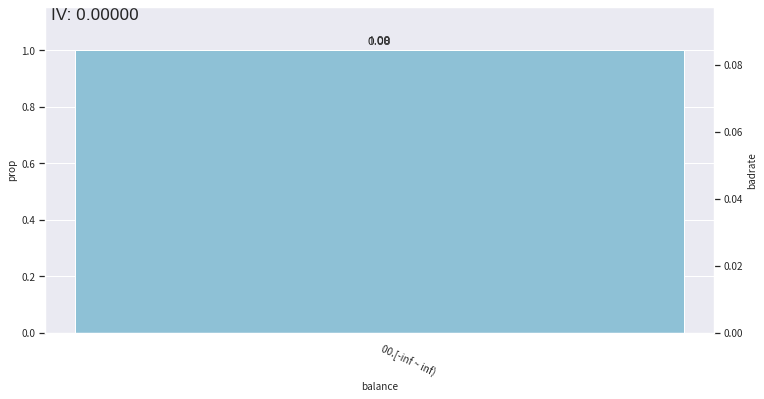

In [48]:
from toad.plot import bin_plot

# Check the bin results of 'var_d2' of in-sample
col = 'balance'

# It's recommended to set 'labels = True' for better visualisation.
bin_plot(c.transform(train_selected[[col,'status']], labels=True), x=col, target='status')

In [49]:
from toad.plot import badrate_plot

col = 'annual_inc'

# Check the stability of 'var_d2''s bins across time
#badrate_plot(c.transform(train[[col,'target','month']], labels=True), target='target', x='month', by=col)
#badrate_plot(c.transform(OOT[[col,'target','month']], labels=True), target='target', x='month', by=col)

#badrate_plot(c.transform(data[[col,'target','month']], labels=True), target='target', x='month', by=col)
'''
A feature is preferrable if the gaps between classes get wider as time goes by - it means the binned classes have larger difference. No line crossing means the bin results are stable.
'''

'\nA feature is preferrable if the gaps between classes get wider as time goes by - it means the binned classes have larger difference. No line crossing means the bin results are stable.\n'

<AxesSubplot:xlabel='balance', ylabel='prop'>

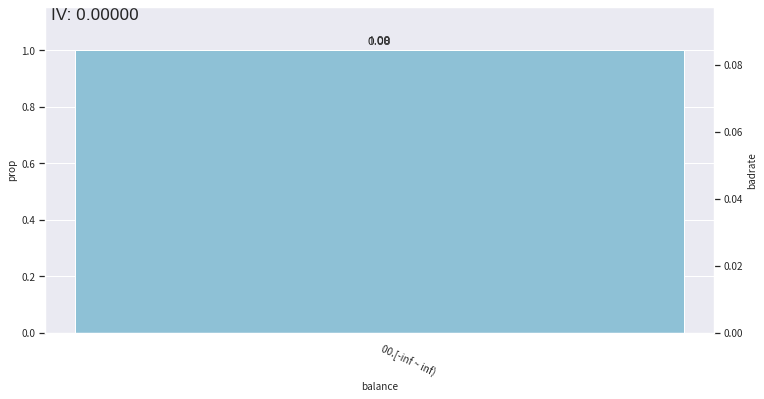

In [50]:
# Check the bin results of var_d5 of in-sample
col = 'balance'

# It's recommended to set 'labels = True' for categorical features.
bin_plot(c.transform(train_selected[[col,'status']], labels=True), x=col, target='status')

In [51]:
# Initialise
transer = toad.transform.WOETransformer()

# transer.fit_transform() & combiner.transform(). Remember to exclude target
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['status'] ,exclude=['status'])
OOT_woe = transer.transform(c.transform(test))

print(train_woe.head(3))

        loan_amount  loan_duration  payments  status  trans_date  \
139023     1.336575       0.351740 -3.825270       0   -0.133216   
65954     -2.426928      -0.508127  1.088038       0   -0.051898   
470699    -2.113093      -0.508127  0.835623       0   -0.133216   

        trans_amount  balance   bank_to  account_to    amount  district_id  \
139023     -0.408453      0.0 -0.358679    0.124976  0.204922    -0.974317   
65954      -0.021961      0.0 -0.557876   -0.255345  0.662490    -0.466092   
470699      0.313912      0.0 -0.310345    0.124976  0.361727     0.198394   

        frequency  account_date   disp_id  disposition_type  
139023  -0.271008      0.229058  0.637317          0.245244  
65954   -0.271008      0.229058 -0.221314          0.245244  
470699  -0.271008     -0.196428 -0.221314          0.245244  


In [52]:
train_woe.head()

,loan_amount,loan_duration,payments,status,trans_date,trans_amount,balance,bank_to,account_to,amount,district_id,frequency,account_date,disp_id,disposition_type
139023,1.336575,0.351740,-3.825270,0,-0.133216,-0.408453,0.0,-0.358679,0.124976,0.204922,-0.974317,-0.271008,0.229058,0.637317,0.245244
65954,-2.426928,-0.508127,1.088038,0,-0.051898,-0.021961,0.0,-0.557876,-0.255345,0.662490,-0.466092,-0.271008,0.229058,-0.221314,0.245244
470699,-2.113093,-0.508127,0.835623,0,-0.133216,0.313912,0.0,-0.310345,0.124976,0.361727,0.198394,-0.271008,-0.196428,-0.221314,0.245244
117808,-2.113093,-0.508127,-0.152686,0,-0.051898,-0.186353,0.0,-0.899861,0.124976,0.204922,-0.466092,-0.271008,-0.327357,-0.221314,-4.151136
517338,-0.650742,0.407204,0.835623,2,0.179723,-0.021961,0.0,-1.013189,0.124976,0.361727,0.729731,0.888359,-0.196428,-0.221314,-4.151136


In [53]:
# Apply stepwise regression on the WOE-transformed data
final_data = toad.selection.stepwise(train_woe,target = 'status', estimator='ols', direction = 'both', criterion = 'aic')# exclude = to_drop)

#  Place the selected features to test / OOT sample
final_OOT = OOT_woe[final_data.columns]

print(final_data.shape) #  Out of 31 features, stepwise regression selected 10 of them.

(7000, 13)


In [54]:

# The final list of features for modelling
col = list(final_data.drop(['status'],axis=1).columns)

In [55]:
toad.metrics.PSI(final_data[col], final_OOT[col])

loan_amount         0.000735
loan_duration       0.001578
payments            0.003128
trans_date          0.000218
bank_to             0.008352
account_to          0.000007
amount              0.002431
district_id         0.001614
frequency           0.000073
account_date        0.001347
disp_id             0.000646
disposition_type    0.000003
dtype: float64

In [56]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(final_data[col], final_data['status'])

# Obtain predicted probability for training and OOT
pred_train = lr.predict_proba(final_data[col])[:,1]

pred_OOT = lr.predict_proba(final_OOT[col])[:,1]
#pred_OOT_june =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-06',col])[:,1]
#pred_OOT_july =lr.predict_proba(final_OOT.loc[final_OOT.month == '2019-07',col])[:,1]

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [57]:
from toad.metrics import KS, AUC

print('train KS',KS(pred_train, final_data['status']))
#print('train AUC',AUC(pred_train, final_data['status']))
print('OOT results')
print('5月 KS',KS(pred_OOT, final_OOT['status']))



train KS 0.6736303411996308
OOT results
5月 KS 0.6823831817983786


In [58]:
toad.metrics.KS_bucket(pred_train, final_data['status'], bucket=10, method = 'quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,6.482628e-09,0.000009,432,267,699,0.618026,0.381974,1.617978,0.057037,-0.465157,...,1.082000,0.057037,1.000000,-0.465157,1.000000,0.099857,1.000000,0.522194,0.571188,0.571188
1,8.722575e-06,0.000087,716,-18,698,1.025788,-0.025788,-39.777778,0.094534,0.031359,...,1.133471,0.151571,0.942963,-0.433798,1.465157,0.199571,0.900143,0.585369,0.948048,0.759483
2,8.760137e-05,0.000317,580,123,703,0.825036,0.174964,4.715447,0.076578,-0.214286,...,1.146886,0.228149,0.848429,-0.648084,1.433798,0.300000,0.800429,0.876233,0.762510,0.760496
3,3.190093e-04,0.001146,747,-48,699,1.068670,-0.068670,-15.562500,0.098627,0.083624,...,1.193061,0.326776,0.771851,-0.564460,1.648084,0.399857,0.700000,0.891236,0.987680,0.817231
4,1.146651e-03,0.003433,830,-134,696,1.192529,-0.192529,-6.194030,0.109585,0.233449,...,1.213759,0.436361,0.673224,-0.331010,1.564460,0.499286,0.600143,0.767372,1.102152,0.873971
5,3.464513e-03,0.010743,726,-21,705,1.029787,-0.029787,-34.571429,0.095854,0.036585,...,1.217974,0.532215,0.563639,-0.294425,1.331010,0.600000,0.500714,0.826641,0.951744,0.887026
6,1.076936e-02,0.028059,674,26,700,0.962857,0.037143,25.923077,0.088989,-0.045296,...,1.265357,0.621204,0.467785,-0.339721,1.294425,0.700000,0.400000,0.960925,0.889886,0.887434
7,2.809971e-02,0.058544,941,-241,700,1.344286,-0.344286,-3.904564,0.124241,0.419861,...,1.366190,0.745445,0.378796,0.080139,1.339721,0.800000,0.300000,0.665306,1.242408,0.931806
8,5.854745e-02,0.133394,976,-276,700,1.394286,-0.394286,-3.536232,0.128862,0.480836,...,1.377143,0.874307,0.254555,0.560976,0.919861,0.900000,0.200000,0.313331,1.288619,0.971452
9,1.334733e-01,0.769708,952,-252,700,1.360000,-0.360000,-3.777778,0.125693,0.439024,...,1.360000,1.000000,0.125693,1.000000,0.439024,1.000000,0.100000,0.000000,1.256932,1.000000


In [59]:
card = toad.ScoreCard(
    combiner = c,
    transer = transer,
    class_weight = 'balanced',
    C=0.1,
    base_score = 600,
    base_odds = 35 ,
    pdo = 60,
    rate = 2
)

card.fit(final_data[col], final_data['status'])

ScoreCard(base_score=600,
          combiner=<toad.transform.Combiner object at 0x00000190C652DC40>,
          transer=<toad.transform.WOETransformer object at 0x00000190D0D894F0>)

In [65]:
model = card.fit(final_data[col], final_data['status'])
print(card.export())

{'loan_amount': {'[-inf ~ 48744)': -54.41, '[48744 ~ 73836)': 73.88, '[73836 ~ 98832)': -0.02, '[98832 ~ 144960)': -66.08, '[144960 ~ 248148)': 65.39, '[248148 ~ 300600)': 58.48, '[300600 ~ inf)': 87.33}, 'loan_duration': {'[-inf ~ 24)': -5.16, '[24 ~ 36)': 34.02, '[36 ~ 48)': 47.68, '[48 ~ 60)': 44.48, '[60 ~ inf)': 12.41}, 'payments': {'[-inf ~ 1354.0)': -86.16, '[1354.0 ~ 2059.0)': 19.77, '[2059.0 ~ 3159.0)': 48.28, '[3159.0 ~ 3931.0)': -93.13, '[3931.0 ~ 5073.0)': 41.57, '[5073.0 ~ 7041.0)': 10.19, '[7041.0 ~ inf)': 55.56}, 'trans_date': {'[-inf ~ 950213)': 19.46, '[950213 ~ 960516)': 14.98, '[960516 ~ 970714)': 12.08, '[970714 ~ 980122)': 40.5, '[980122 ~ inf)': 37.86}, 'bank_to': {'ST': 9.2, 'WX': 10.87, 'QR': 15.07, 'CD': 15.93, 'UV': 18.87, 'YZ': 19.59, 'AB': 19.6, 'IJ': 22.86, 'GH': 24.32, 'KL': 29.77, 'EF': 29.84, 'OP': 36.27, 'MN': 36.87}, 'account_to': {'[-inf ~ 64831644)': 22.8, '[64831644 ~ inf)': 26.99}, 'amount': {'[-inf ~ 510.0)': -2.29, '[510.0 ~ 1177.0)': 36.56, '[11

In [66]:
# Output standard scorecard
model.export()

{'loan_amount': {'[-inf ~ 48744)': -54.41,
  '[48744 ~ 73836)': 73.88,
  '[73836 ~ 98832)': -0.02,
  '[98832 ~ 144960)': -66.08,
  '[144960 ~ 248148)': 65.39,
  '[248148 ~ 300600)': 58.48,
  '[300600 ~ inf)': 87.33},
 'loan_duration': {'[-inf ~ 24)': -5.16,
  '[24 ~ 36)': 34.02,
  '[36 ~ 48)': 47.68,
  '[48 ~ 60)': 44.48,
  '[60 ~ inf)': 12.41},
 'payments': {'[-inf ~ 1354.0)': -86.16,
  '[1354.0 ~ 2059.0)': 19.77,
  '[2059.0 ~ 3159.0)': 48.28,
  '[3159.0 ~ 3931.0)': -93.13,
  '[3931.0 ~ 5073.0)': 41.57,
  '[5073.0 ~ 7041.0)': 10.19,
  '[7041.0 ~ inf)': 55.56},
 'trans_date': {'[-inf ~ 950213)': 19.46,
  '[950213 ~ 960516)': 14.98,
  '[960516 ~ 970714)': 12.08,
  '[970714 ~ 980122)': 40.5,
  '[980122 ~ inf)': 37.86},
 'bank_to': {'ST': 9.2,
  'WX': 10.87,
  'QR': 15.07,
  'CD': 15.93,
  'UV': 18.87,
  'YZ': 19.59,
  'AB': 19.6,
  'IJ': 22.86,
  'GH': 24.32,
  'KL': 29.77,
  'EF': 29.84,
  'OP': 36.27,
  'MN': 36.87},
 'account_to': {'[-inf ~ 64831644)': 22.8, '[64831644 ~ inf)': 26.99}

In [75]:
model.predict(loan[:1])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([276.08471982])

In [62]:
data.head()

,loan_date,loan_amount,loan_duration,payments,status,trans_date,trans_type,operation,trans_amount,balance,...,bank_to,account_to,amount,district_id,frequency,account_date,disp_id,disposition_type,card_type,issued_date
139023,941103,61056,48,1272.0,0,970331,PRIJEM,NaN,150.1,39642.0,...,UV,6799704,1978.0,1,POPLATEK MESICNE,931121,7241,OWNER,NaN,NaN
65954,940531,104808,12,8734.0,0,941209,PRIJEM,VKLAD,25970.0,51298.6,...,CD,85405385,735.0,66,POPLATEK MESICNE,931126,210,OWNER,NaN,NaN
470699,971208,30276,12,2523.0,0,961231,VYDAJ,VYBER,14.6,63153.5,...,YZ,1301700,2523.2,68,POPLATEK MESICNE,960728,31,OWNER,NaN,NaN
117808,940928,23052,12,1921.0,0,940124,VYDAJ,VYBER,4200.0,18331.8,...,WX,34075695,1921.0,54,POPLATEK MESICNE,930119,4621,DISPONENT,NaN,NaN
517338,980427,93888,36,2608.0,2,980106,PRIJEM,VKLAD,24155.0,53843.1,...,ST,27251911,2608.2,2,POPLATEK TYDNE,970616,3285,DISPONENT,NaN,NaN


In [63]:
data.columns

Index(['loan_date', 'loan_amount', 'loan_duration', 'payments', 'status',
       'trans_date', 'trans_type', 'operation', 'trans_amount', 'balance',
       'k_symbol', 'bank', 'account', 'bank_to', 'account_to', 'amount',
       'district_id', 'frequency', 'account_date', 'disp_id',
       'disposition_type', 'card_type', 'issued_date'],
      dtype='object')

In [77]:
gbdt_transer = toad.transform.GBDTTransformer()
gbdt_transer.fit(final_data[col+['status']], 'status', n_estimators = 10, max_depth = 2)

X has feature names, but DecisionTreeRegressor was fitted without feature names


In [78]:
gbdt_vars = gbdt_transer.transform(final_data[col])

X has feature names, but DecisionTreeRegressor was fitted without feature names


In [79]:
gbdt_vars.shape

(28000, 40)

In [81]:
import pickle

In [82]:
pickle.dump(model,open('model.pkl','wb'))

In [85]:
pickle_model = pickle.load(open('model.pkl','rb'))

In [86]:
pickle_model.predict(loan[:1])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


array([276.08471982])